In [1]:
import os
import os.path as p
import warnings
warnings.filterwarnings("ignore")

import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import play_wave

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
audio_data = pd.read_csv('instruments.csv')

data_dir = r'../../data/freesound-audio-tagging/audio_train'

# Noise detection in random recordings

Noise is generated due to the presence of air around the microphone. The movement of air molecules causes a bombardment on the diaphragm, which eventually ends up as noise. - https://www.dpamicrophones.com/mic-university/the-basics-about-noise-in-mics

Randomly will select 5 recording and will inspect whether there is noise which should be removed.

In [3]:
random_recordings = audio_data.sample(5, random_state=42)
random_recordings

fname        label
203  195f544d.wav        Cello
266  f5e20dce.wav        Flute
152  444f9db5.wav  Double_bass
9    c40632d7.wav    Saxophone
233  ce3f3400.wav    Bass_drum

In [4]:
NOISE_AMPLITUDE_THRESHOLD = 0.005

def load_signal(filename):
    signal, sample_rate = librosa.load(p.join(data_dir, filename))
    return signal, sample_rate


def plot_signal(signal, instrument, title, color):
    plt.figure(figsize=(20, 5))
    plt.plot(signal, c=color)
    plt.title(f"{instrument} - {title}")
    plt.xlim(0, len(signal))
    plt.show()   

    
def envelope(signal, sample_rate):
    window_size = int(sample_rate / 10)
    
    rolling_mean_amplitude = pd.Series(np.abs(signal))\
                            .rolling(window=window_size, min_periods=1, center=True)\
                            .mean()
    return rolling_mean_amplitude


def plot_around_noise_threshold(signal_around_noise, rolling_mean_around_noise):
    plt.figure(figsize=(20, 5))

    plt.plot(np.abs(signal_around_noise), c='gray', linestyle=':', label='signal')
    plt.plot(rolling_mean_around_noise.values, c='orange', label='envelope')
    
    # Plot threshold
    time = range(len(signal_around_noise))
    threshold = [NOISE_AMPLITUDE_THRESHOLD] * len(signal_around_noise)
    plt.plot(time, threshold, c='green')

    plt.xlim(0, len(signal_around_noise))
    plt.ylim(0)

    plt.title("Transition in amplitude from noise to sound")
    plt.legend(loc='best')
    plt.show()
    

def process_signal(row):
    signal, sample_rate = load_signal(row.fname)
    
    print(f'---------------------------> {row.label}')
    plot_signal(signal, row.label, 'raw recording', 'gray')
    
    rolling_mean_signal = envelope(signal, sample_rate)
    noise_mask = rolling_mean_signal > NOISE_AMPLITUDE_THRESHOLD
    plot_signal(signal[noise_mask], row.label, 'noise removed', 'C0')
    
    print('Play audio')
    play_wave(signal, sample_rate)
    print('Play audio with noise removed')
    play_wave(signal[noise_mask], sample_rate)

    first_non_noise_frame = np.maximum(np.argmax(noise_mask), np.argmin(noise_mask))
    
    start_index = np.maximum(first_non_noise_frame - 500, 0)
    end_index = first_non_noise_frame + 500
    plot_around_noise_threshold(signal[start_index:end_index], rolling_mean_signal[start_index:end_index])

---------------------------> Cello


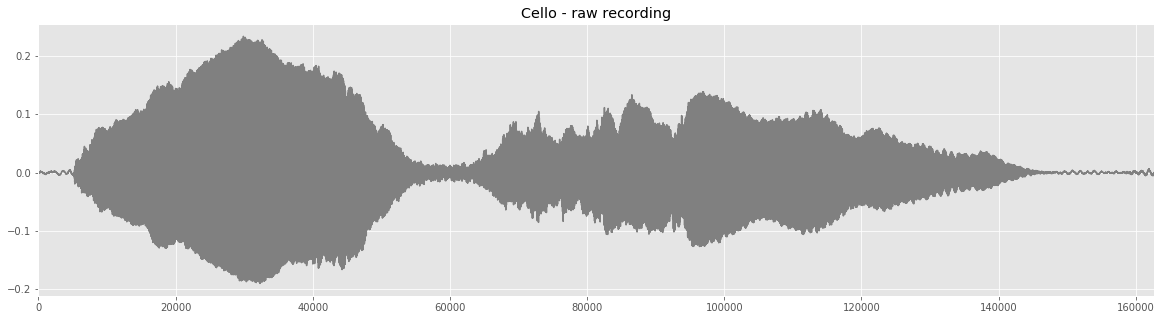

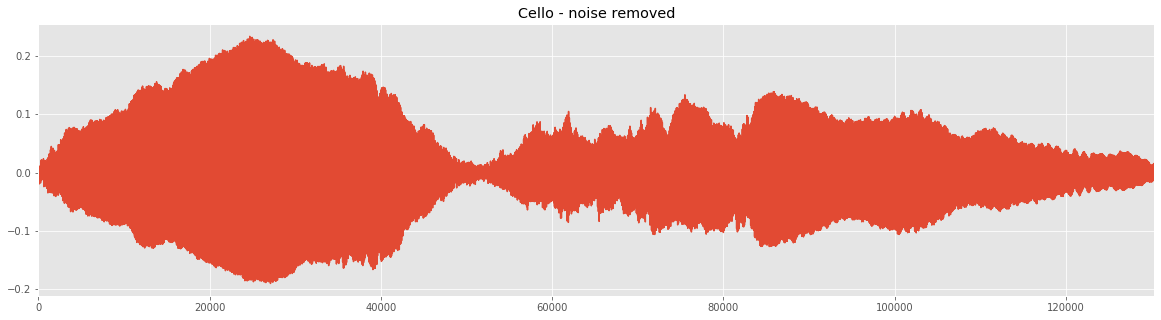

Play audio


Play audio with noise removed


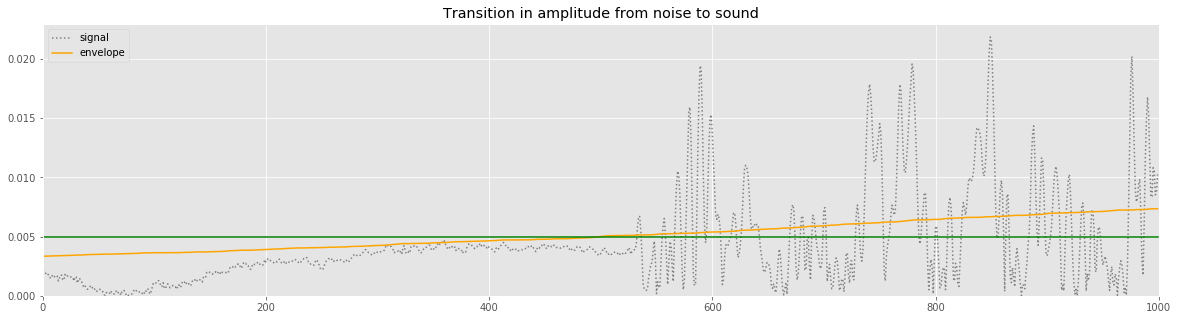

---------------------------> Flute


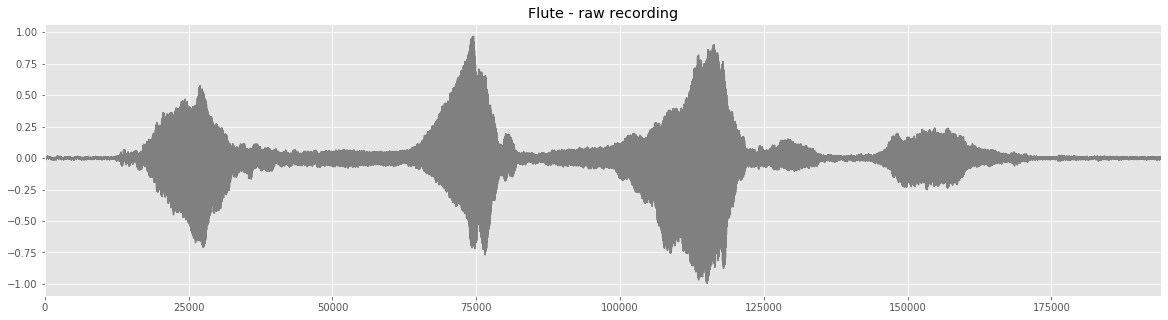

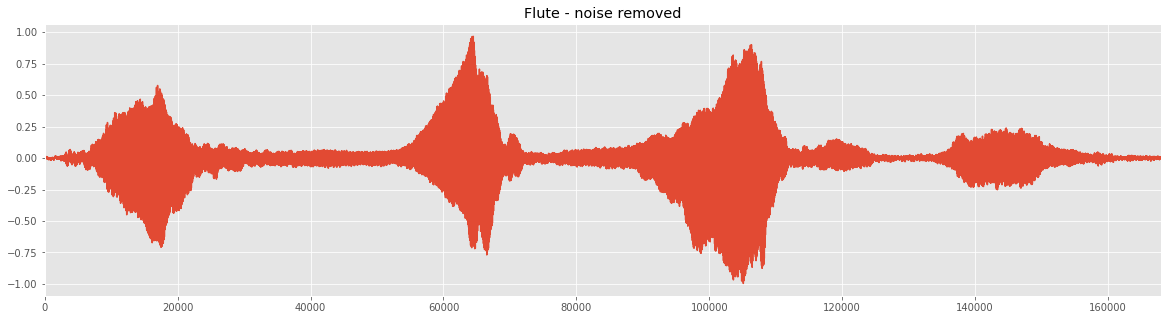

Play audio


Play audio with noise removed


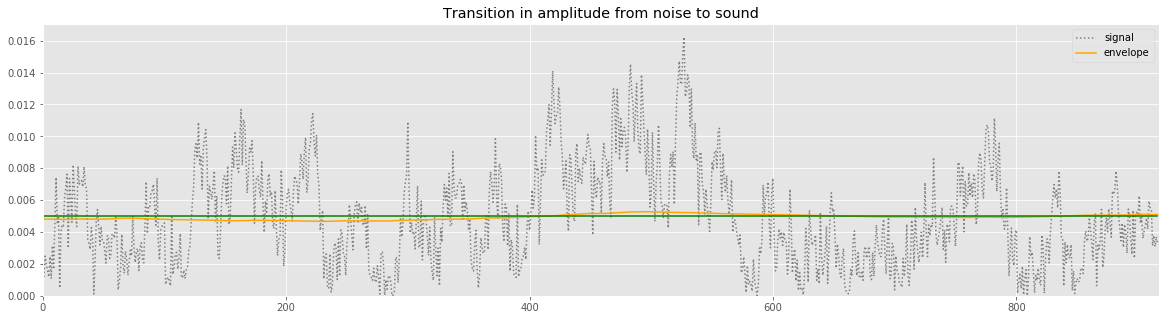

---------------------------> Double_bass


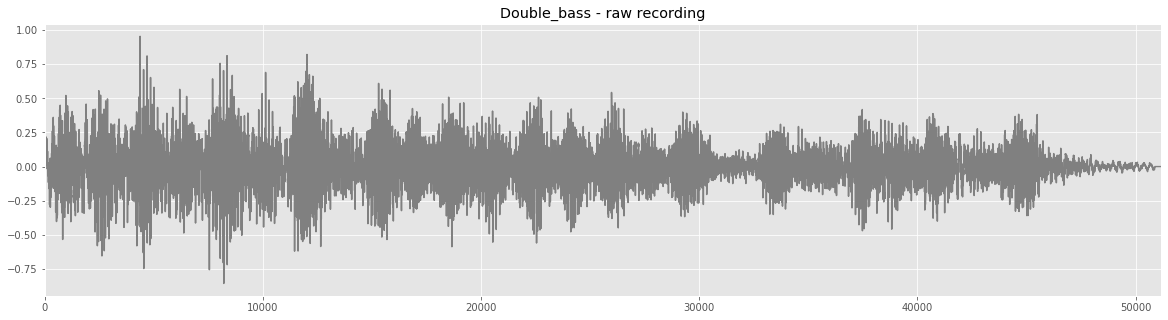

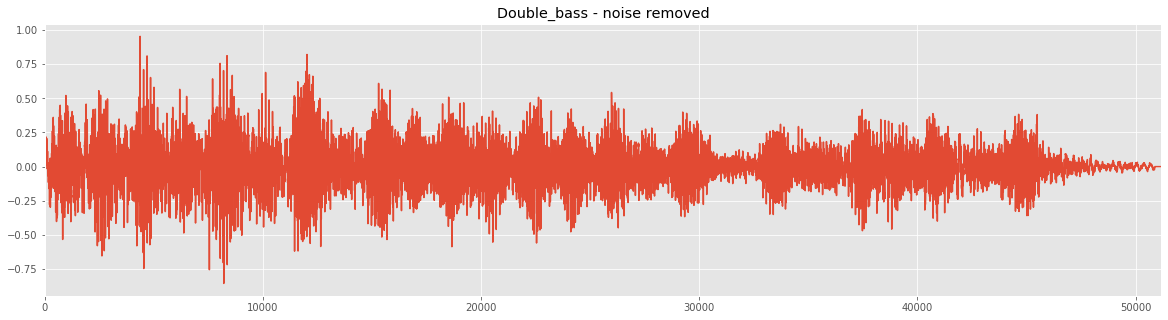

Play audio


Play audio with noise removed


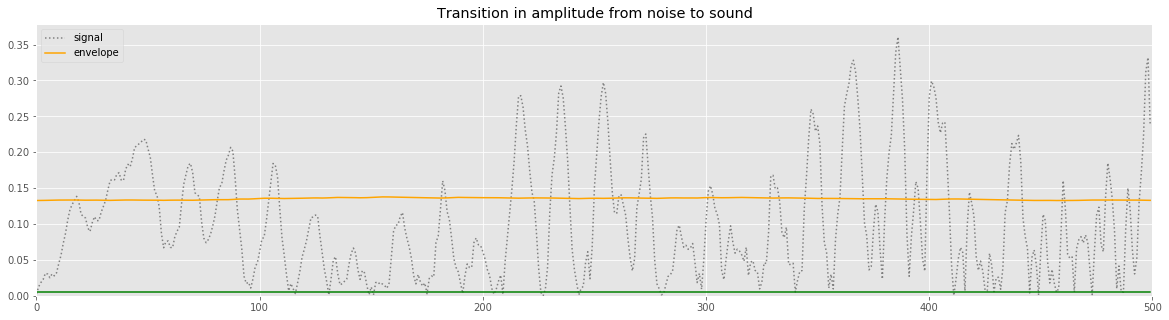

---------------------------> Saxophone


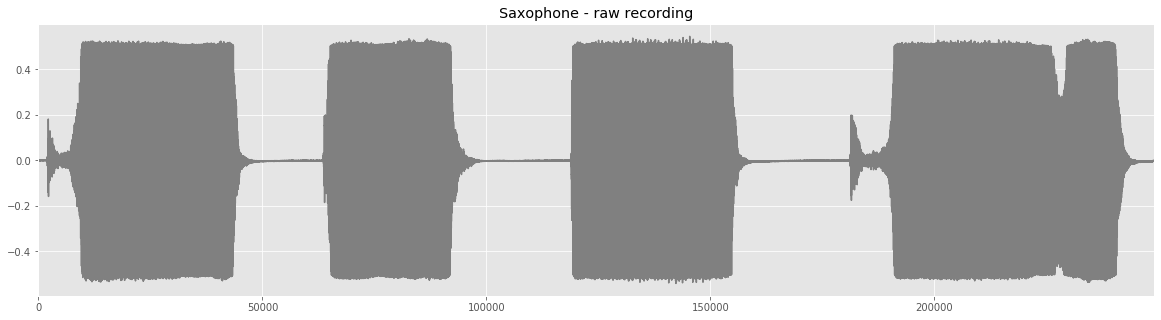

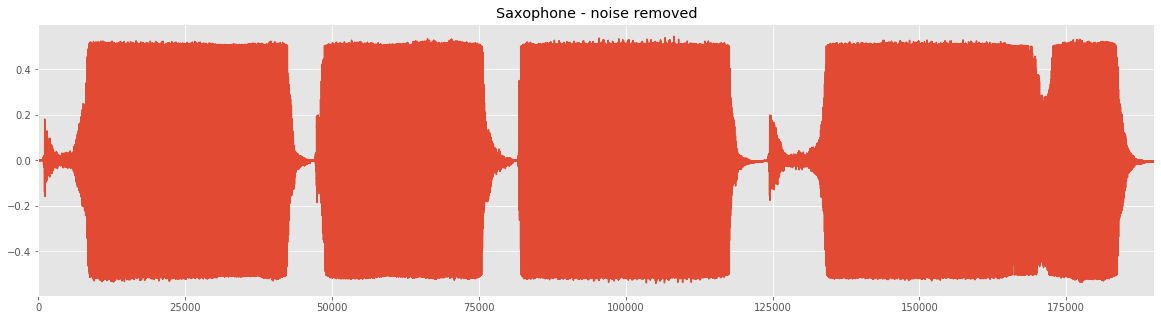

Play audio


Play audio with noise removed


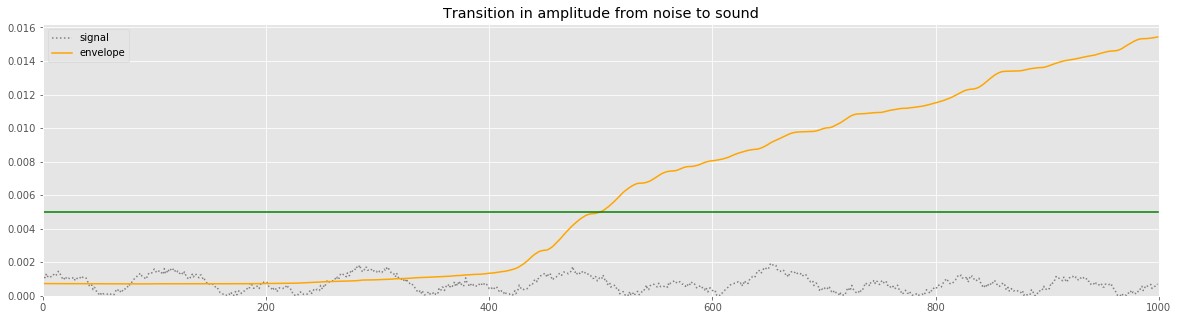

---------------------------> Bass_drum


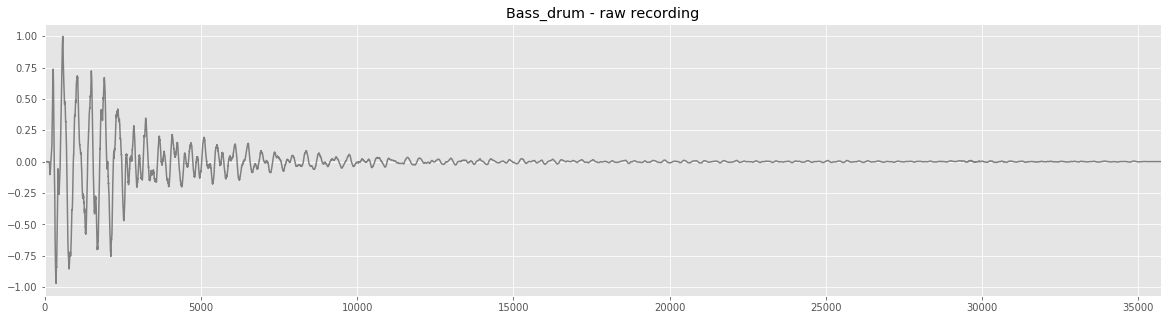

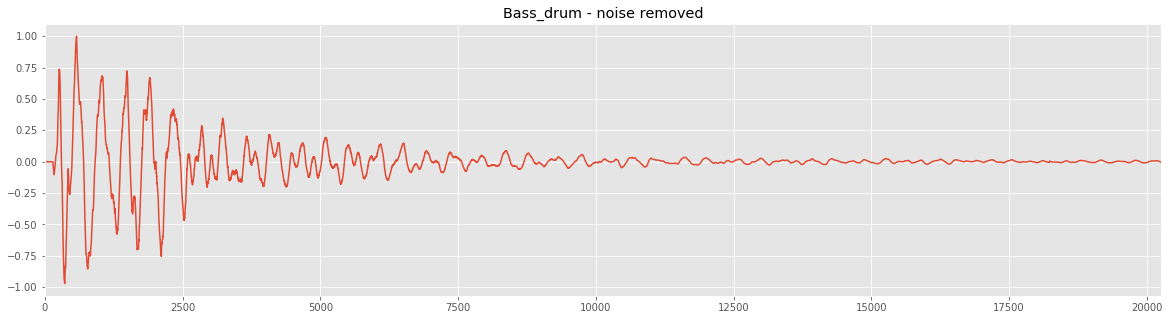

Play audio


Play audio with noise removed


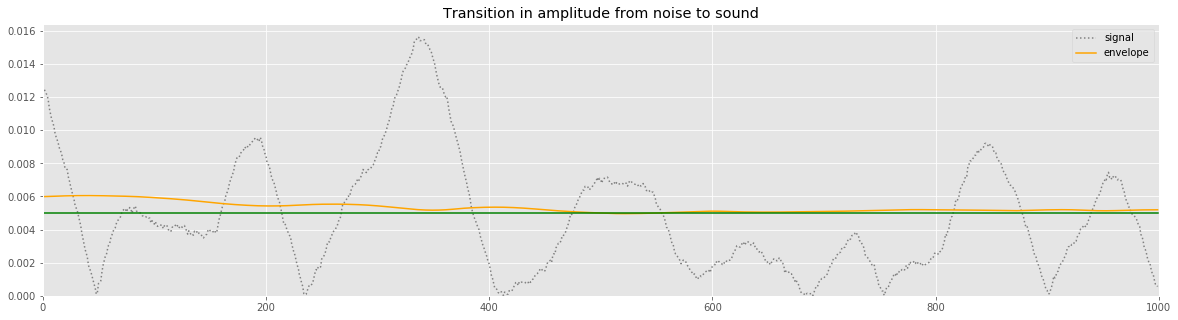

203    None
266    None
152    None
9      None
233    None
dtype: object

In [5]:
random_recordings.apply(process_signal, axis=1)

> **NOTES**: There is no noice in the double bass recording.